# Intro

### Credits
This notebook contains a solution with an AWD LSTM network.

The data cleaning part is from [Alexander Tesemnikov](https://www.kaggle.com/alexandertesemnikov/bert-pytorch-pretrained-fine-tuning).

**If you find this notebook helpful, please upvote his input! 🙏🙂**

### Short Info

* **fast.ai** Databunch and Learner
* **AWD LSTM** Neural Network
* **Google Colab** Environment



# 0 Google Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# 1 Import Libraries


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

#Check the present working directory using pwd command

# 2 Load Data

In [ ]:
!kaggle competitions download -c nlp-getting-started

In [ ]:
path=Path("/content/gdrive/My Drive/Kaggle")

In [ ]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Kaggle/kaggle.json'),
 PosixPath('/content/gdrive/My Drive/Kaggle/test.csv'),
 PosixPath('/content/gdrive/My Drive/Kaggle/sample_submission.csv'),
 PosixPath('/content/gdrive/My Drive/Kaggle/train.csv')]

In [ ]:
train_df= pd.read_csv(path/"train.csv")
test_df= pd.read_csv(path/"test.csv")
sample_df= pd.read_csv(path/"sample_submission.csv")

#3 Data Preparation

In [ ]:
train_df = train_df[["text","target"]]
test_df = test_df[['text','id']]

In [ ]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [ ]:
def clean(text):
    """
    Text preprocessing function.
    """
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_df['text_cleaned'] = train_df['text'].apply(lambda s : clean(s))
test_df['text_cleaned'] = test_df['text'].apply(lambda s : clean(s))

# 4 Definition of Models

In [ ]:
X_train, X_val = train_test_split(train_df,test_size = 0.05)

In [ ]:
data_lm = TextLMDataBunch.from_df(path=path,
 train_df = X_train,
 valid_df = X_val,
 test_df = test_df,
 label_cols="target", 
 text_cols="text_cleaned")

# 5 Language Model Creation

In [ ]:
lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
lm.save_encoder(path/'awd_lstm_cleaned_2.pth')

# 7 Classification Model Creation

In [ ]:
data_clas=TextClasDataBunch.from_df(
    path=path,train_df=X_train, 
    valid_df=X_val, 
    test_df=test_df, 
    vocab=data_lm.train_ds.vocab, 
    text_cols="text_cleaned", 
    label_cols="target")

In [ ]:
clas = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.3)

In [ ]:
clas.load_encoder(path/"awd_lstm_cleaned_2.pth")

# 8 Optimization of Model

In [ ]:
clas.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 2.09E-02


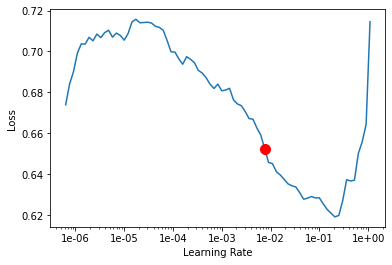

In [ ]:
clas.recorder.plot(suggestion=True)

In [ ]:
clas.fit_one_cycle(5, max_lr=7.59E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.536187,0.470429,0.766404,00:06
1,0.517887,0.494179,0.774278,00:06
2,0.491864,0.461063,0.790026,00:06
3,0.472643,0.450723,0.790026,00:06
4,0.451845,0.447374,0.800525,00:06


In [ ]:
clas.save('lstm-stage1-cleaned-2')

In [ ]:
clas.load('lstm-stage1')

In [ ]:
clas.unfreeze()

In [ ]:
clas.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-08


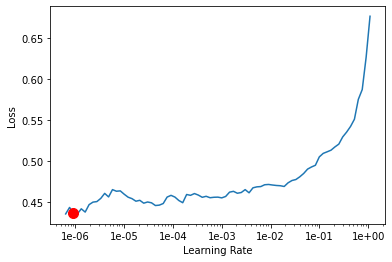

In [ ]:
clas.recorder.plot(suggestion=True)

In [ ]:
clas.fit_one_cycle(10, max_lr=9.12E-07)

epoch,train_loss,valid_loss,accuracy,time
0,0.452789,0.448938,0.790026,00:17
1,0.446349,0.446784,0.795276,00:17
2,0.456628,0.446983,0.784777,00:17
3,0.457214,0.443085,0.790026,00:17
4,0.450695,0.442334,0.800525,00:17
5,0.435755,0.440959,0.792651,00:17
6,0.434349,0.440816,0.792651,00:17
7,0.439957,0.441236,0.800525,00:17
8,0.437432,0.441888,0.800525,00:17
9,0.447739,0.439723,0.790026,00:17


In [ ]:
clas.save('lstm-stage2-cleaned-2')

In [ ]:
clas.unfreeze()

In [ ]:
clas.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.91E-07


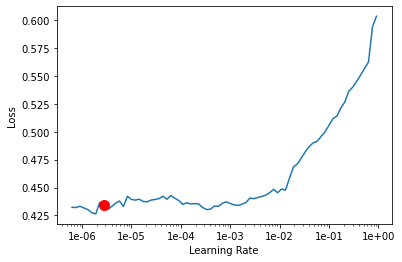

In [ ]:
clas.recorder.plot(suggestion=True)

In [ ]:
clas.fit_one_cycle(10, max_lr=1E-03)

epoch,train_loss,valid_loss,accuracy,time
0,0.436719,0.413139,0.818898,00:17
1,0.409595,0.394818,0.826772,00:17
2,0.344946,0.445592,0.803150,00:17
3,0.244326,0.565940,0.795276,00:17
4,0.166885,0.662358,0.758530,00:17
5,0.113914,0.757855,0.800525,00:17
6,0.077983,0.772827,0.811024,00:17
7,0.062315,0.759683,0.824147,00:17
8,0.047815,0.725536,0.826772,00:17
9,0.041299,0.728611,0.826772,00:17


In [ ]:
clas.save('lstm-stage3-cleaned-2')

# 7 Vorhersage

In [ ]:
p,t = clas.get_preds(ds_type=DatasetType.Test)

In [ ]:
p = to_np(p)
p.shape

(3263, 2)

In [ ]:
preds = np.argmax(p, axis = 1)
preds

array([1, 1, 1, 1, ..., 1, 1, 1, 1])

# 8 Einreichung bei Kaggle

In [ ]:
sub_df = test_df

In [ ]:
sub_df['target'] = preds

In [ ]:
final_sub = sub_df[['id','target']]

In [ ]:
final_sub.to_csv(path/"wt103_awd-lstm.csv", index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f wt103_awd-lstm.csv -m "AWD LSTM"

100% 22.2k/22.2k [00:03<00:00, 7.53kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets